<a href="https://colab.research.google.com/github/jongbokhi/master_thesis_2023/blob/main/Adversarial_sample_wcgan_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall seaborn

In [ ]:
!pip install table_evaluator

In [ ]:
!pip install seaborn==0.11.1

In [ ]:
from table_evaluator import TableEvaluator

import tensorflow as tf

from functools import partial
import itertools
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats


from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding, multiply, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import warnings
warnings.simplefilter("ignore")

In [ ]:
df_ids2018 = pd.read_csv('/content/drive/MyDrive/new_cic_ids_2018 data/extracted_ft_dos')

In [ ]:
##Sampling
df_ids2018 = df_ids2018.sample(frac=0.1, random_state=12).reset_index(drop=True)

print('Class distribution: ')
df_ids2018['Label'].value_counts()

Class distribution: 


0    119027
1     19758
Name: Label, dtype: int64

In [ ]:
##Sort the feature and Target variable
x_train = df_ids2018.drop('Label', axis=1).copy()
y_train = df_ids2018['Label'].copy()

In [ ]:
# Scaling
numerical_cols_train = x_train.columns

In [ ]:
scaler = MinMaxScaler()
x_train[numerical_cols_train] = scaler.fit_transform(x_train[numerical_cols_train])

In [ ]:
x_train

,Bwd IAT Tot,Bwd Pkt Len Max,Flow Duration,Flow IAT Min,Fwd Header Len,Fwd IAT Mean,Fwd IAT Min,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Std,Fwd Pkts/s,Fwd Seg Size Min,Init Bwd Win Byts,Init Fwd Win Byts,Tot Bwd Pkts,TotLen Bwd Pkts,TotLen Fwd Pkts
0,0.017678,0.623936,0.019444,7.252154e-07,0.001603,0.002779,7.252154e-07,0.033769,0.000000,0.051361,8.571577e-07,0.454545,0.959061,0.125015,0.000907,0.000141,0.000134
1,0.000333,0.192021,0.036334,7.502229e-08,0.001565,0.009086,2.167310e-07,0.046638,0.000000,0.094140,2.866887e-07,0.727273,0.003235,0.003632,0.000389,0.000032,0.000109
2,0.001078,0.203723,0.036771,5.835067e-08,0.001565,0.009196,1.409669e-04,0.046638,0.000000,0.094140,2.832821e-07,0.727273,0.003448,0.003632,0.000518,0.000034,0.000109
3,0.000469,0.182447,0.028063,6.668648e-08,0.001565,0.007018,7.418871e-07,0.046638,0.000000,0.094140,3.711933e-07,0.727273,0.003235,0.003357,0.000389,0.000031,0.000109
4,0.000000,0.096809,0.000016,1.562964e-05,0.000075,0.000000,0.000000e+00,0.002095,0.028767,0.000000,1.333333e-04,0.181818,0.000000,0.000000,0.000130,0.000016,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138780,0.001204,0.075000,0.043357,3.167608e-07,0.001230,0.008674,3.167608e-07,0.025788,0.000000,0.046255,2.883037e-07,0.454545,0.000931,0.125015,0.000389,0.000013,0.000070
138781,0.000743,0.184574,0.033984,6.668648e-08,0.001565,0.008499,2.083952e-07,0.046638,0.000000,0.094140,3.065148e-07,0.727273,0.003235,0.003357,0.000389,0.000031,0.000109
138782,0.045346,0.623936,0.046890,1.833878e-07,0.001975,0.005212,2.300683e-06,0.032971,0.000000,0.044521,4.443053e-07,0.454545,0.959366,0.125015,0.001555,0.000196,0.000151
138783,0.000679,0.497340,0.034285,5.001486e-08,0.001155,0.011365,8.203270e-05,0.016660,0.000000,0.037598,2.430619e-07,0.454545,0.003357,0.000015,0.000518,0.000083,0.000039


### Model Definition

In [ ]:
class RandomWeightedAverage(tf.keras.layers.Layer):
    """Provides a (random) weighted average between real and generated samples"""

    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        alpha = tf.random.uniform((self.batch_size, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

class WCGANGP():
    def __init__(self,
                 x_train,
                 y_train,
                 latent_dim: int,
                 batch_size: int,
                 n_critic: int):
        """Implement WCGAN with Gradient Penalty.

        Most of the hyperparameteres were taken from this paper:
        https://www.researchgate.net/publication/347437993_Synthesising_Tabular_Data_using_Wasserstein_Conditional_GANs_with_Gradient_Penalty_WCGAN-GP

        and from the Improved WGAN paper:
        https://arxiv.org/abs/1704.00028

        Attributes
        ---------
        x_train : numpy.ndarray
            Real data without labels used for training.
            (Created with sklearn.model_selection.train_test_split

        y_train : numpy.ndarray
            Real data labels.

        data_dim : int
            Data dimension. Number of columns in `x_train`.

        latent_dim : int
            Dimension of random noise vector (z), used for training
            the generator.

        batch_size : int
            Size of training batch in each epoch.

        n_critic : int
            Number of times the critic (discriminator) will be trained
            in each epoch.

        """

        self.x_train = x_train
        self.y_train = y_train

        self.num_classes = len(np.unique(y_train))
        self.data_dim = x_train.shape[1]

        self.latent_dim = latent_dim
        self.batch_size = batch_size

        self.n_critic = n_critic

        # Log training progress.
        self.losslog = []

        # Adam optimizer, suggested by original paper.
        optimizer = Adam(learning_rate=0.0005, beta_1=0.05, beta_2=0.9)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()


        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic.
        self.generator.trainable = False

        # Data input (real sample).
        real_data = Input(shape=self.data_dim)
        # Noise input (z).
        noise = Input(shape=(self.latent_dim,))
        # Label input.
        label = Input(shape=(1,))

        # Generate data based of noise (fake sample)
        fake_data = self.generator([noise, label])

        # Critic (discriminator) determines validity of the real and fake images.
        fake = self.critic([fake_data, label])
        valid = self.critic([real_data, label])

        # Construct weighted average between real and fake images.
        interpolated_data = RandomWeightedAverage(self.batch_size)([real_data, fake_data])

        # Determine validity of weighted sample.
        validity_interpolated = self.critic([interpolated_data, label])


        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument.
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_data)
        # Keras requires function names.
        partial_gp_loss.__name__ = 'gradient_penalty'

        self.critic_model = Model(inputs=[real_data, label, noise],
                            outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                  optimizer=optimizer,
                                  loss_weights=[1, 1, 10])

        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers.
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator.
        noise = Input(shape=(self.latent_dim,))

        # Add label to input.
        label = Input(shape=(1,))

        # Generate data based of noise.
        fake_data = self.generator([noise, label])

        # Discriminator determines validity.
        valid = self.critic([fake_data, label])

        # Define generator model.
        self.generator_model = Model([noise, label], valid)
        self.generator_model.compile(loss=self.wasserstein_loss,
                                     optimizer=optimizer)


    def generate_adversarial_samples(self, num_samples):
        """Generate adversarial samples."""
        noise = np.random.normal(0, 1, (num_samples, self.latent_dim))
        benign_labels = np.ones((num_samples, 1))  # Change this if you want to mimic another class
        adversarial_samples = self.generator.predict([noise, benign_labels])

        return adversarial_samples, benign_labels


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]

        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)

        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - abs(gradient_l2_norm))

        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        """Computes Wasserstein loss from real and fake predictions."""
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential(name="Generator")

        # First hidden layer.
        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        # Second hidden layer.
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        # Third hidden layer.
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        # Output layer.
        model.add(Dense(self.data_dim, activation="sigmoid"))

        model.summary()

        # Noise and label input layers.
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype="int32")

        # Embed labels into onehot encoded vectors.
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        # Multiply noise and embedded labels to be used as model input.
        model_input = multiply([noise, label_embedding])

        generated_data = model(model_input)

        return Model([noise, label], generated_data, name="Generator")

    def build_critic(self):

        model = Sequential(name="Critic")

        # First hidden layer.
        model.add(Dense(512, input_dim=self.data_dim))
        model.add(LeakyReLU(alpha=0.2))

        # Second hidden layer.
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))

        # Third hidden layer.
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))

        # Output layer with linear activation.
        model.add(Dense(1))

        model.summary()

        # Artificial data input.
        generated_sample = Input(shape=self.data_dim)
        # Label input.
        label = Input(shape=(1,), dtype="int32")

        # Embedd label as onehot vector.
        label_embedding = Flatten()(Embedding(self.num_classes, self.data_dim)(label))

        # Multiply fake data sample with label embedding to get critic input.
        model_input = multiply([generated_sample, label_embedding])

        validity = model(model_input)

        return Model([generated_sample, label], validity, name="Critic")

    def train(self, epochs):

        # Adversarial ground truths.
        valid = -(np.ones((self.batch_size, 1)))
        fake =  np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1))

        # Number of batches.
        self.n_batches = math.floor(self.x_train.shape[0] / self.batch_size)

        overhead = self.x_train.shape[0] % self.batch_size

        for epoch in range(epochs):

            # Reset training set.
            self.x_train = x_train.copy()
            self.y_train = y_train.copy()

            # Select random overhead rows that do not fit into batches.
            rand_overhead_idx = np.random.choice(range(self.x_train.shape[0]), overhead, replace=False)

            # Remove random overhead rows.
            self.x_train = self.x_train.to_numpy()
            self.y_train = self.y_train.to_numpy()

            self.x_train = np.delete(self.x_train, rand_overhead_idx, axis=0)
            self.y_train = np.delete(self.y_train, rand_overhead_idx, axis=0)

            # Split training data into batches.
            x_batches = np.split(self.x_train, self.n_batches)
            y_batches = np.split(self.y_train, self.n_batches)

            for x_batch, y_batch, i in zip(x_batches, y_batches, range(self.n_batches)):

                for _ in range(self.n_critic):

                    # ---------------------
                    #  Train Critic
                    # ---------------------

                    # Generate random noise.
                    noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))

                    # Train the critic.
                    d_loss = self.critic_model.train_on_batch(
                        [x_batch, y_batch, noise],
                        [valid, fake, dummy])


                # ---------------------
                #  Train Generator
                # ---------------------

                # Generate sample of artificial labels.
                generated_labels = np.random.randint(0, self.num_classes, self.batch_size).reshape(-1, 1)

                # Generate adversarial labels (benign).
                adversarial_labels = np.ones((self.batch_size, 1))

                # Train generator.
                g_loss = self.generator_model.train_on_batch([noise, adversarial_labels], valid)


                # ---------------------
                #  Logging
                # ---------------------

                self.losslog.append([d_loss[0], g_loss])

                DLOSS = "%.4f" % d_loss[0]
                GLOSS = "%.4f" % g_loss

                if i % 100 == 0:
                    print(f"{epoch} - {i}/{self.n_batches} \t [D loss: {DLOSS}] [G loss: {GLOSS}]")

**Model training**

In [ ]:
wcgan = WCGANGP(
    x_train,
    y_train,
    latent_dim=64,
    batch_size=256,
    n_critic=5)

wcgan.train(epochs=15)

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               16640     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 1024)              52

## Generate adversarial samples


In [ ]:
adversarial_samples, adversarial_labels = wcgan.generate_adversarial_samples(10000)

In [ ]:
adversarial_samples.shape

(10000, 17)

In [ ]:
adversarial_samples_df = pd.DataFrame(adversarial_samples, columns=x_train.columns.tolist())

In [ ]:
adversarial_samples_df

,Bwd IAT Tot,Bwd Pkt Len Max,Flow Duration,Flow IAT Min,Fwd Header Len,Fwd IAT Mean,Fwd IAT Min,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Std,Fwd Pkts/s,Fwd Seg Size Min,Init Bwd Win Byts,Init Fwd Win Byts,Tot Bwd Pkts,TotLen Bwd Pkts,TotLen Fwd Pkts
0,2.833966e-12,2.382096e-12,0.004996,0.000041,3.996164e-07,1.097205e-06,0.000158,4.230955e-13,3.814945e-07,1.064633e-07,4.838615e-17,0.763086,0.002996,1.087338e-08,6.936606e-04,0.000013,1.616992e-15
1,1.245509e-06,4.775821e-07,0.011615,0.000003,5.340709e-04,4.027747e-08,0.000003,2.599236e-07,5.655501e-06,1.488510e-04,3.641706e-14,0.753554,0.001003,2.657844e-04,8.907944e-04,0.006297,6.679589e-13
2,2.135338e-08,8.383985e-08,0.021451,0.000010,4.614913e-05,9.494780e-07,0.000028,5.761583e-09,5.176159e-06,5.957004e-05,3.757816e-14,0.751277,0.000887,2.319973e-05,8.943108e-04,0.000055,7.738829e-13
3,2.226342e-02,4.906238e-01,0.104085,0.000001,7.227120e-03,1.696706e-07,0.000001,1.693659e-02,9.322003e-05,6.893458e-02,7.378635e-11,0.742049,0.000110,4.305811e-01,2.269206e-05,0.000037,1.106075e-09
4,9.376377e-06,3.731925e-05,0.023187,0.000002,1.266786e-03,9.300657e-08,0.000003,3.865804e-06,1.168649e-05,6.934254e-04,2.685166e-13,0.758023,0.000453,2.028380e-03,3.222966e-04,0.000690,5.099003e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.209757e-04,1.621602e-03,0.041372,0.000002,3.650200e-03,1.615085e-07,0.000003,8.108624e-05,2.697267e-05,4.315972e-03,2.590247e-12,0.755017,0.000290,1.834222e-02,1.774738e-04,0.000273,4.381639e-11
9996,1.585564e-06,1.387923e-05,0.023242,0.000002,4.781958e-04,1.498405e-07,0.000004,7.745123e-07,7.890459e-06,4.457794e-04,1.156152e-13,0.752467,0.000342,7.029290e-04,3.318248e-04,0.000086,2.280398e-12
9997,5.436806e-11,4.027273e-11,0.005110,0.000024,2.718777e-06,4.413578e-07,0.000060,1.178481e-11,7.316373e-07,6.205607e-07,2.446972e-16,0.758518,0.002675,1.091604e-07,8.726373e-04,0.000080,6.715658e-15
9998,1.046202e-05,9.147715e-05,0.028893,0.000002,1.220769e-03,1.543263e-07,0.000004,5.659321e-06,1.417726e-05,1.185218e-03,4.836024e-13,0.757044,0.000368,2.875007e-03,2.636412e-04,0.000248,9.117617e-12


In [ ]:
y_train_df = pd.DataFrame(y_train, columns=['Label'])

In [ ]:
adversarial_labels_df = pd.DataFrame(adversarial_labels, columns=y_train_df.columns.tolist())

In [ ]:
adversarial_labels_df

,Label
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
9995,1.0
9996,1.0
9997,1.0
9998,1.0


# Save adversarial data to CSV file

In [ ]:
adversarial_samples_df.to_csv('/content/drive/MyDrive/adversarial data_wcgangp/adversarial_samples.csv', index=False)
adversarial_labels_df.to_csv('/content/drive/MyDrive/adversarial data_wcgangp/adversarial_label.csv', index=False)

In [ ]:
def normal_distribution(r, f):

	r_x = np.linspace(r.min(), r.max(), len(r))
	f_x = np.linspace(f.min(), f.max(), len(f))

	r_y = scipy.stats.norm.pdf(r_x, r.mean(), r.std())
	f_y = scipy.stats.norm.pdf(f_x, f.mean(), f.std())

	n, bins, patches = plt.hist([r, f], density = True, alpha = 0.5, color = ["green", "red"])
	xmin, xmax = plt.xlim()

	plt.plot(r_x, r_y, color = "green", label = "Original data", alpha = 0.5)
	plt.plot(f_x, f_y, color = "red", label = "Generated data", alpha = 0.5)
	title = f"Original Data: Mean {np.round(r.mean(), 4)}, Std {np.round(r.std(), 4)}, Var {np.round(r.var(), 4)} \n Generated Data: Mean {np.round(f.mean(), 4)}, Std {np.round(f.std(), 4)}, Var {np.round(f.var(), 2)}"
	plt.title(title)
	plt.legend()
	plt.grid()
	plt.show()

Bwd IAT Tot Normal distribution


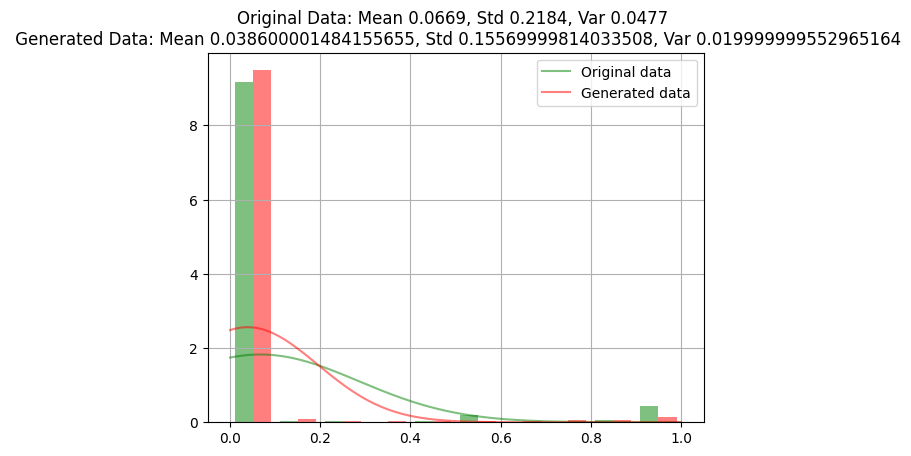

Bwd Pkt Len Max Normal distribution


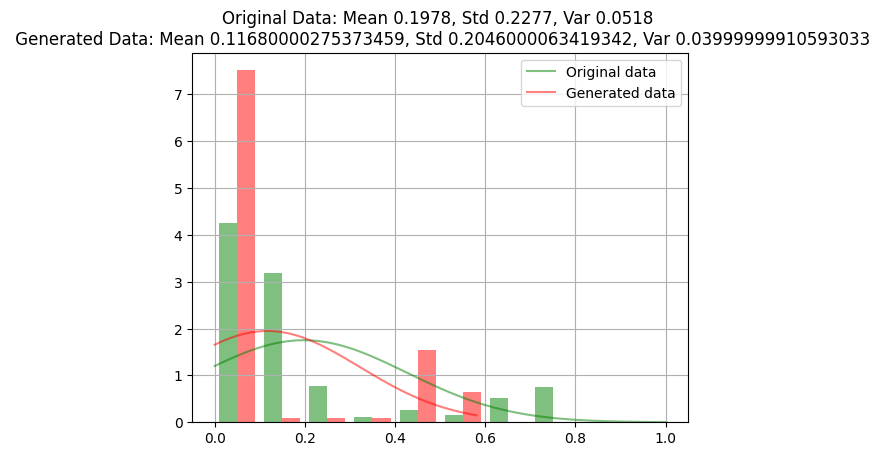

Flow Duration Normal distribution


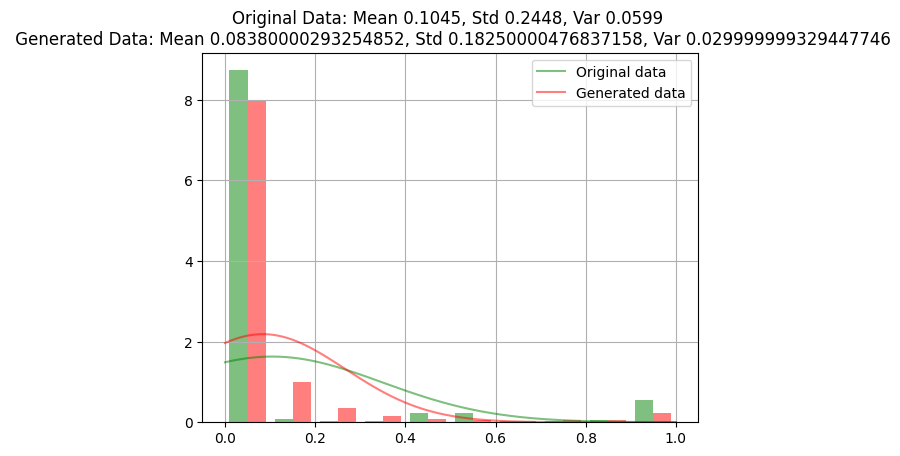

Flow IAT Min Normal distribution


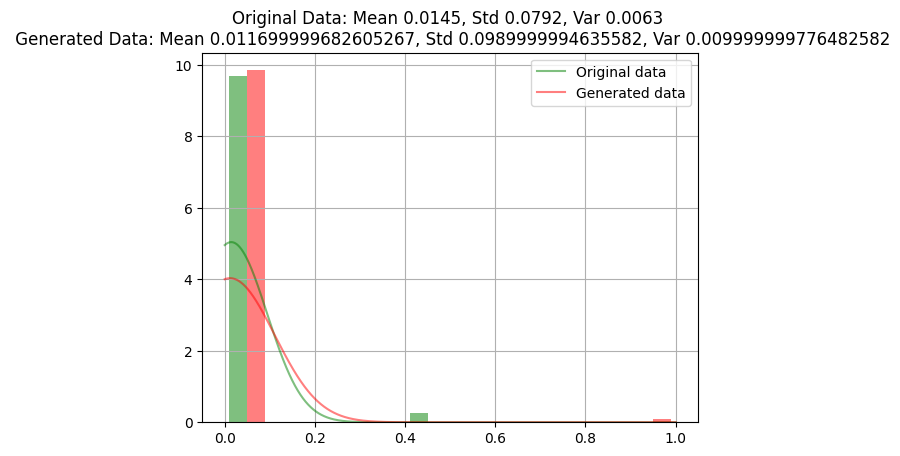

Fwd Header Len Normal distribution


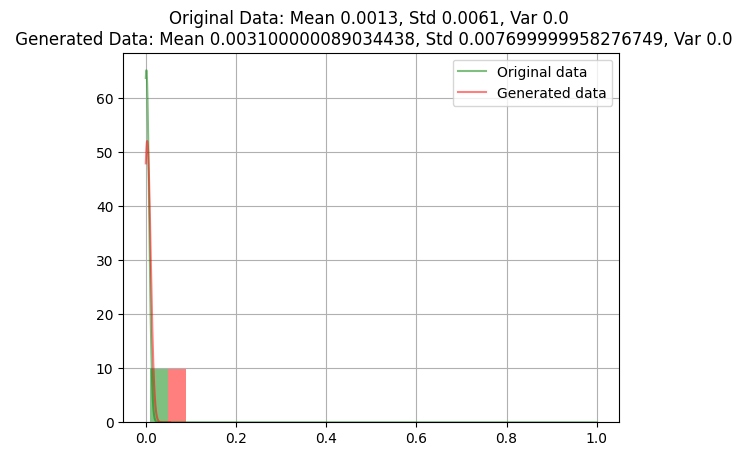

Fwd IAT Mean Normal distribution


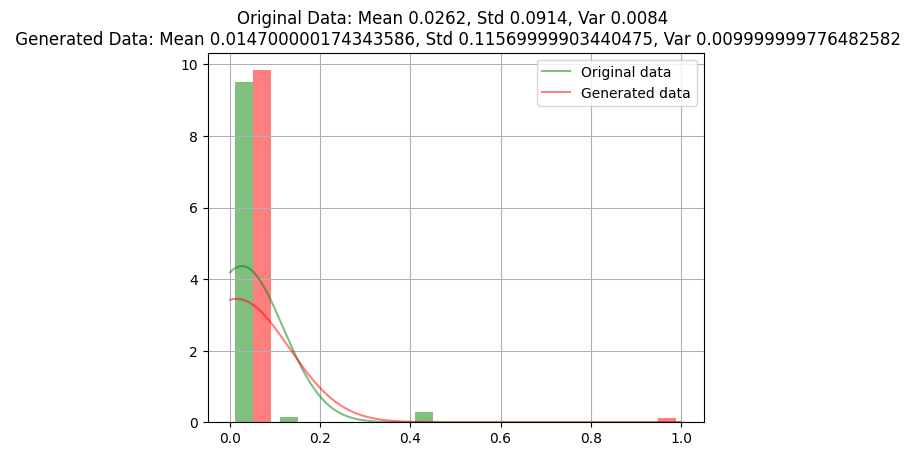

Fwd IAT Min Normal distribution


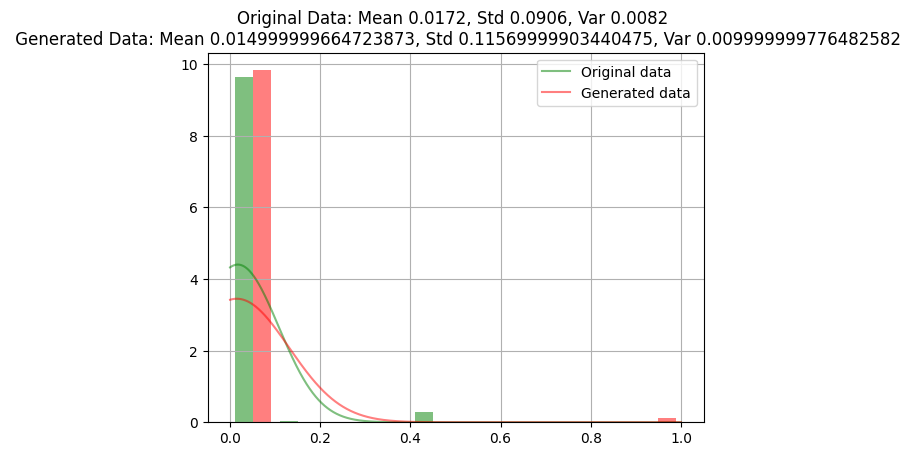

Fwd Pkt Len Max Normal distribution


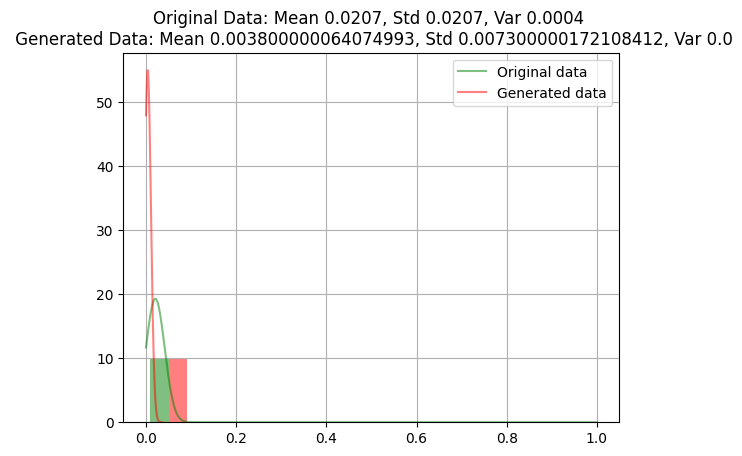

Fwd Pkt Len Min Normal distribution


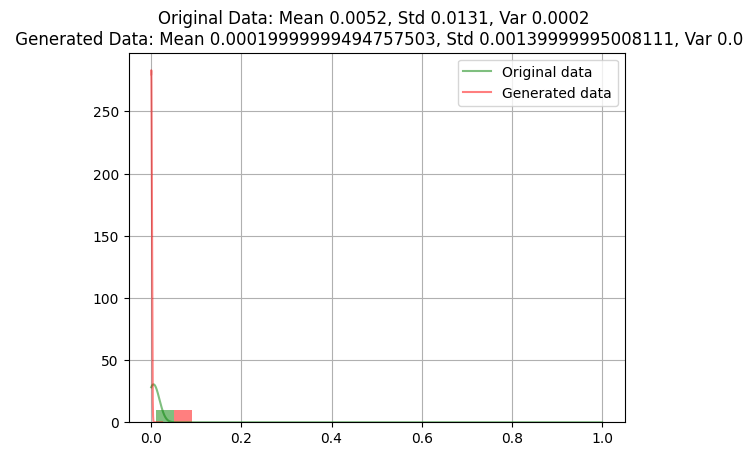

Fwd Pkt Len Std Normal distribution


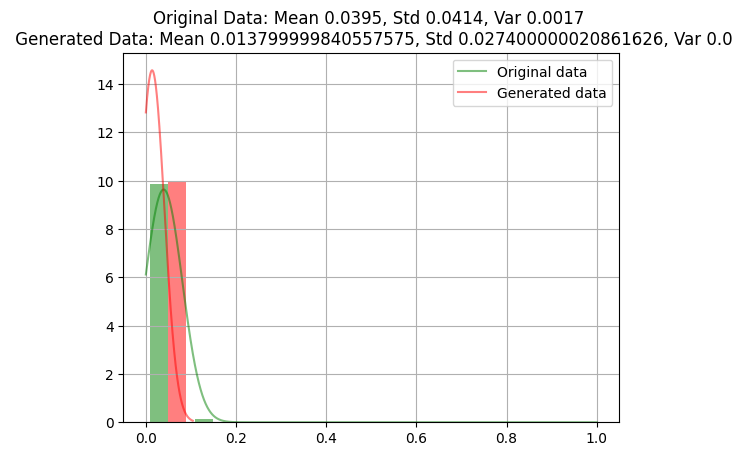

Fwd Pkts/s Normal distribution


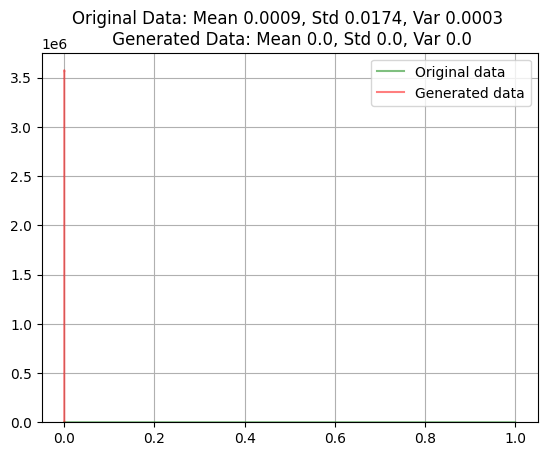

Fwd Seg Size Min Normal distribution


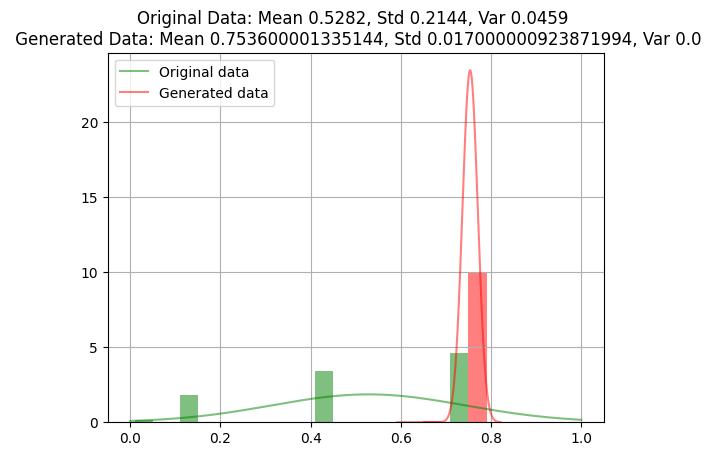

Init Bwd Win Byts Normal distribution


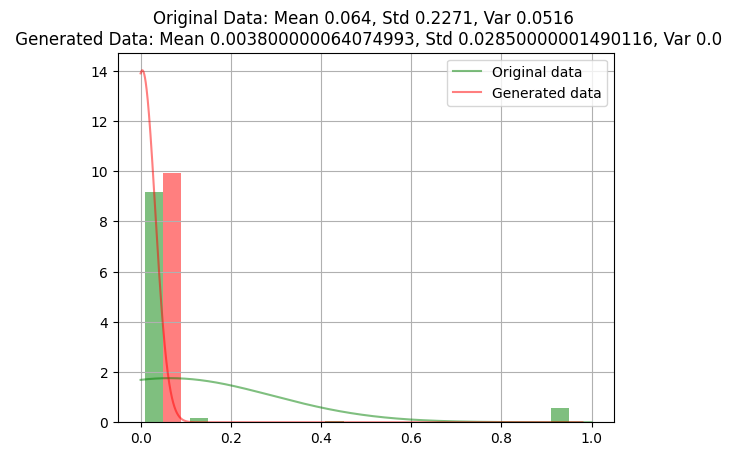

Init Fwd Win Byts Normal distribution


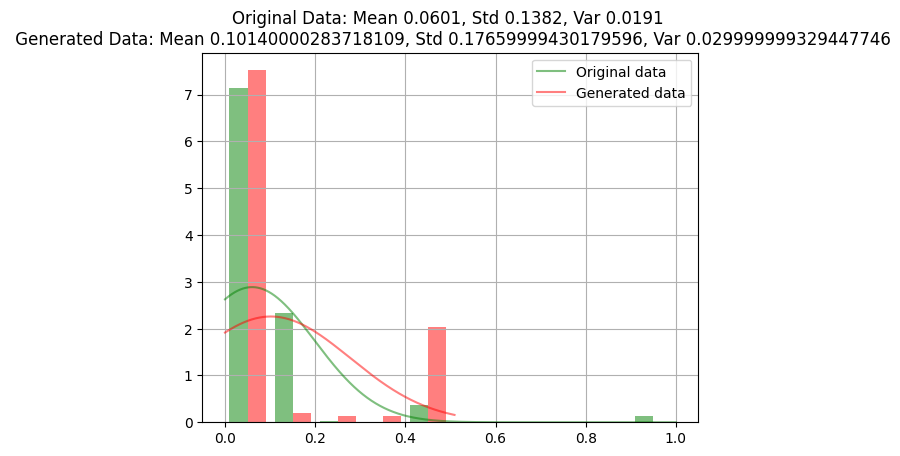

Tot Bwd Pkts Normal distribution


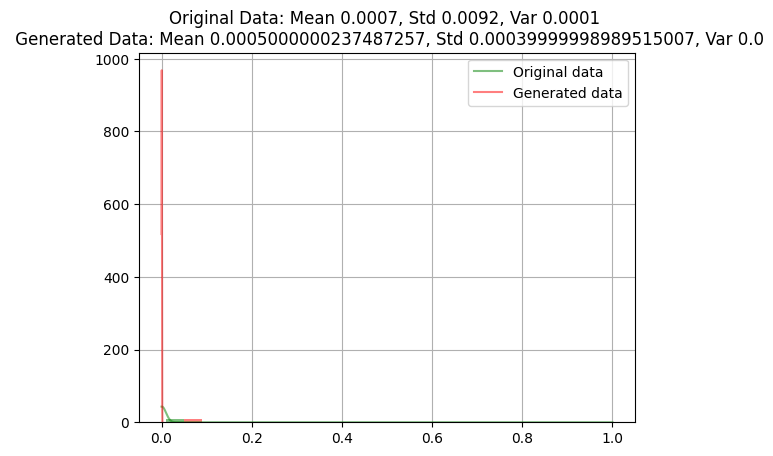

TotLen Bwd Pkts Normal distribution


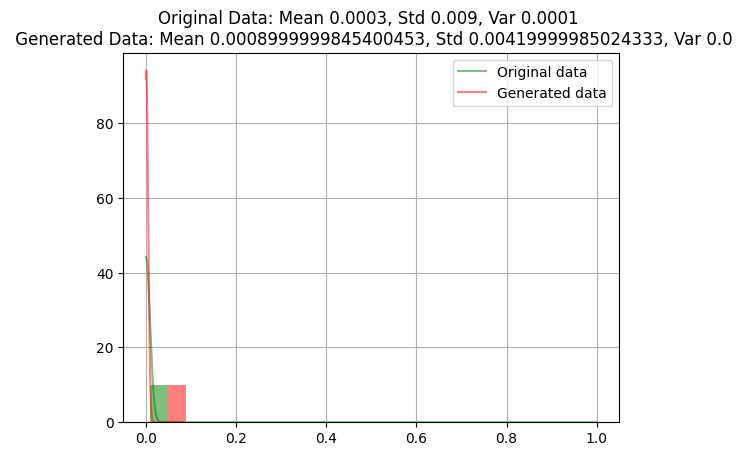

TotLen Fwd Pkts Normal distribution


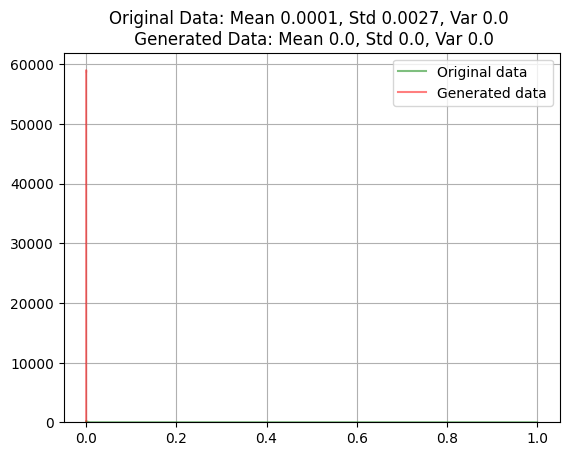

In [ ]:
for column in adversarial_samples_df.columns:
    print(column, "Normal distribution")
    normal_distribution(x_train[column], adversarial_samples_df[column])

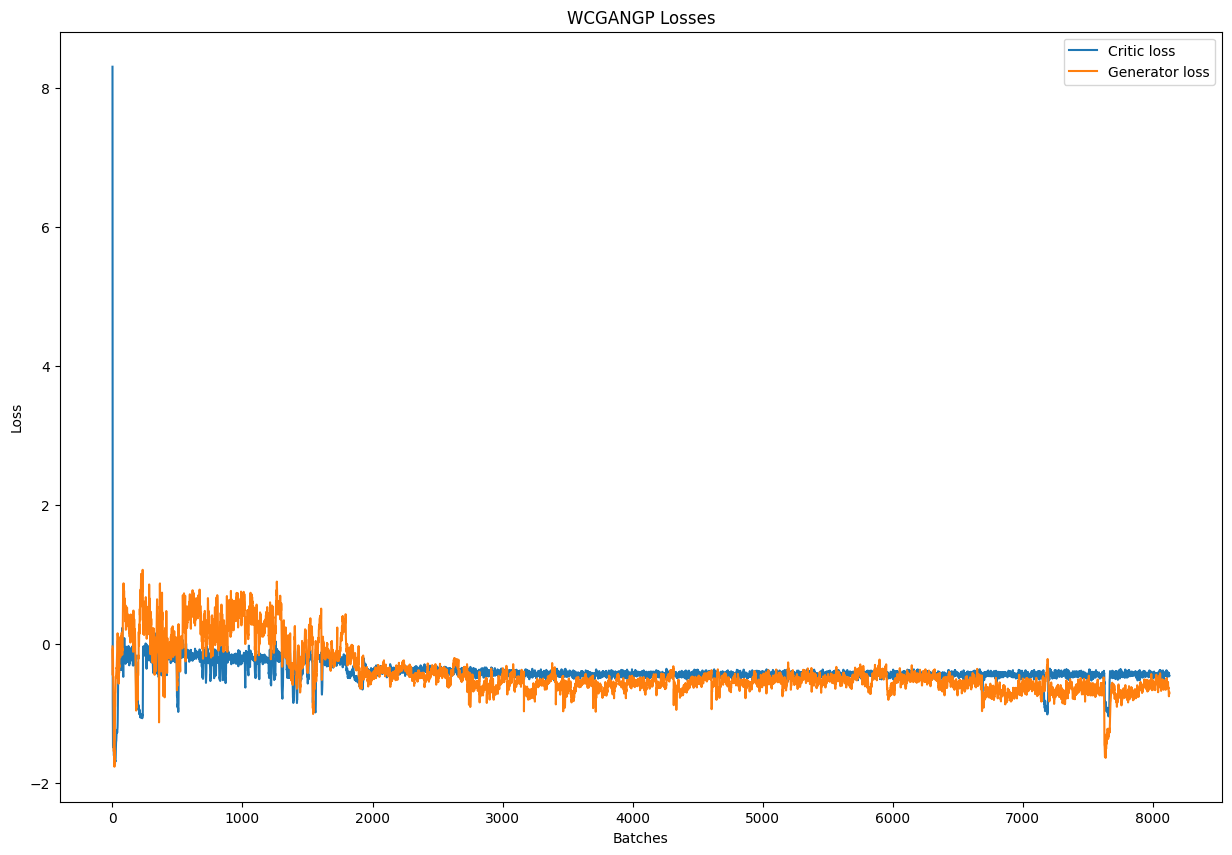

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(wcgan.losslog)
plt.title("WCGANGP Losses")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend(['Critic loss', 'Generator loss'])

#Save the Generator and Critic

In [ ]:
wcgan.generator.save("/content/drive/MyDrive/saved_models/wcgan_generator.h5")
wcgan.critic.save("/content/drive/MyDrive/saved_models/wcgan_critic.h5")

In [ ]:
'''
Load saved generator and critic

from tensorflow.keras.models import load_model

model_generator = load_model("/content/drive/MyDrive/saved_models/wcgan_generator.h5")

model_critic = load_model("/content/drive/MyDrive/saved_models/wcgan_critic.h5")

'''

#Check the misclassification rate of Critic

In [ ]:
predictions = wcgan.critic.predict([adversarial_samples, adversarial_labels])

In [ ]:
predictions

array([[0.7057326 ],
       [0.70655966],
       [0.7068216 ],
       ...,
       [0.7061723 ],
       [0.706197  ],
       [0.73642385]], dtype=float32)

In [ ]:
# Convert the predicted probabilities to predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
predicted_labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Compare the predicted labels with the actual adversarial labels
misclassified = np.where(predicted_labels != adversarial_labels.flatten())[0]
misclassification_rate = len(misclassified) / len(adversarial_labels)

In [ ]:
# Print the misclassification rate
print("Misclassification Rate:", misclassification_rate)

Misclassification Rate: 1.0


#Check the accuracy pretrained ML model by using Adversarial data

In [ ]:
from sklearn.metrics import accuracy_score
import joblib

model = joblib.load("/content/drive/MyDrive/saved_models/logisticregression_v2.pkl")

In [ ]:
adversarial_predictions = model.predict(adversarial_samples_df)
adversarial_accuracy = accuracy_score(adversarial_labels_df, adversarial_predictions)
print("Accuracy on adversarial samples: ", adversarial_accuracy)

Accuracy on adversarial samples:  0.3222
